In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
plt.style.use('dark_background')
from vscode_dark_ipywidget_fix.inject_css import inject_css
inject_css()

from icecream import ic
from fft_tdse.fouriergrid import fftgrid
from fft_tdse.simulator import LaserPulse, Simulator
import pickle

from gauss1d import LCGauss1D, Gauss1D
import numpy as np

from time_steppers import heun_step, rk4_step



gaussians = Gauss1D()

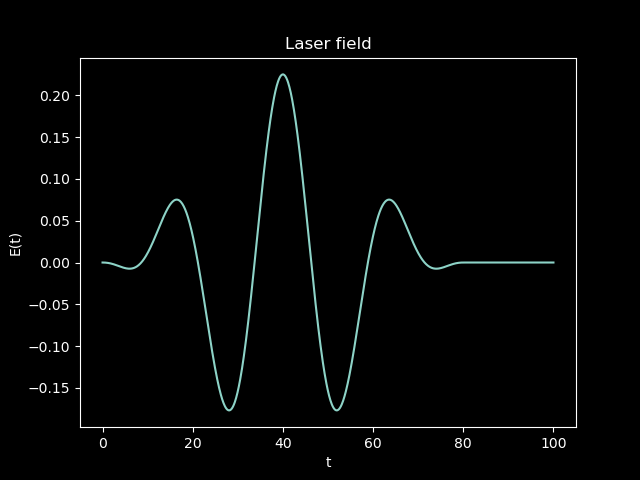

ic| f'dt adjusted from {dt0} to {dt} to have a whole number of time steps = {t_steps}.': 'dt adjusted from 0.01 to 0.01 to have a whole number of time steps = 10000.'
ic| simulator.py:283 in set_propagator() at 08:31:15.220
ic| message: 'Propagation method set to "strang-3"'
ic| message: 'Grid set.'
ic| self.a: array([-100.])
    self.b: array([100.])
    self.n: array([2048])


In [2]:
# Grid
grid_a = -100
grid_b = 100
grid_ng = 2048


# time grid
dt0 = 0.01
t_final = 100

# read laser field params
laser_omega = 0.25
laser_nc = 1
laser_E0 = 0.225
#t_c = (2*np.pi/laser_omega)

laser = LaserPulse(omega = laser_omega, t0 = 0, T = 80, E0=laser_E0)

# plot laser
t_range = np.linspace(0, t_final, 1000)
plt.figure()
plt.plot(t_range, laser(t_range))
plt.xlabel('t')
plt.ylabel('E(t)')
plt.title('Laser field')
plt.show()

# Time grid
t_steps = int(round(t_final / dt0))
dt = t_final / t_steps
ic(f'dt adjusted from {dt0} to {dt} to have a whole number of time steps = {t_steps}.')
t_range = np.arange(0.0, t_final+dt, dt)

# Set up laser field
def U_fun(t, x):
    return laser(t) * x

# Set up simulator object, for reference calculations later
grid_sim = Simulator()
grid_sim.set_grid(grid_a, grid_b, grid_ng)
x = grid_sim.grid.x[0]



In [8]:
# load initial state from pickle
fname = 'lcg_fit_ngauss_10_active_abqp.pkl'
with open(fname, 'rb') as f:
    initial_state = pickle.load(f)
    c_init = initial_state['c']
    z_init = initial_state['z']
    #z0 = z0[:,:1]
    #c0 = c0[:1]
    name = initial_state['name']
    n_gauss = len(c_init)
    lcgi = LCGauss1D(gaussians)
    lcgi.set_z(z_init)
    lcgi.set_c(c_init)
    psi_init = lambda x: lcgi.eval_grid(np.array(x))
    grid_sim.set_initial_condition(psi_init)
    
    
fname = 'lcg_smoothed_coulomb_ngauss_20_p_1.pkl'
with open(fname, 'rb') as f:
    potential = pickle.load(f)
    c_pot = potential['c']
    z_pot = potential['z']
    ic(z_pot.shape)
    
    lcg = LCGauss1D(gaussians)
    lcg.set_z(z_pot)
    V = lcg.eval_grid(x, c_pot)
    ic(np.linalg.norm(V.imag))
    ic(np.linalg.norm(V.real))
    V = V.real
    # This function is used in the grid simulator
    V_fun = lambda x: lcg.eval_grid(np.array(x), c_pot).real
    grid_sim.set_potential(V_fun)

grid_sim.set_time_parameters(0, t_final, t_steps)
grid_sim.set_laser_pulse(laser)
grid_sim.prepare()


df = LCGauss1D(gaussians)
df.set_potential(c_pot, z_pot)
df.set_z(z_init)
odefun = df.get_odefun(laser)
odefun_imag_time = df.get_odefun_imag_time()

ic| message: 'Initial condition set as a callable.'
ic| z_pot.shape: (4, 20)
ic| np.linalg.norm(V.imag): 1.0717604379149016e-11
ic| np.linalg.norm(V.real): 4.747936558806808
ic| message: 'Potential function set set.'
ic| 'Time parameters set.'
ic| self.t0: 0, self.t1: 100, self.n_steps: 10000
ic| message: 'Laser pulse set.'
ic| 'Using given initial condition function. '


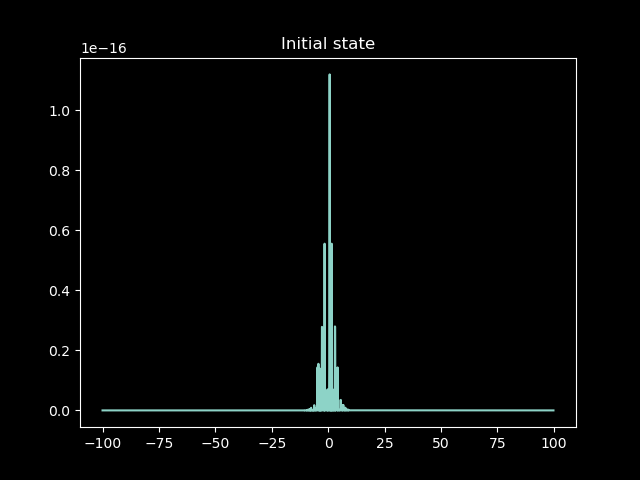

In [19]:

plt.figure()
psi0 = lcgi.eval_grid(x)
plt.plot(x, np.abs(psi_init(x) - df.eval_grid(x, c_init)))
plt.title('Initial state')
plt.show()




In [20]:

psi = np.zeros((grid_ng, len(t_range)+1), dtype=complex)
c = np.zeros((n_gauss, len(t_range)), dtype=complex)
z = np.zeros((n_gauss * df.n_par, len(t_range)), dtype=complex)
c[:,0] = c_init
z[:,0] = z_init.flatten()
x_expect = np.zeros(len(t_range)+1)
psi_norm = np.zeros(len(t_range)+1)
A_cond = np.zeros(len(t_range)+1)
S_cond = np.zeros(len(t_range)+1)


dx = x[1]-x[0]

df.set_z(z_init)
df.set_c(c_init)
y0 = df.par_to_vec(c_init, z_init)
psi[:,0] = df.eval_grid(x)

ic(df.n_pot)


ic| df.n_pot: 20


20

In [13]:



def get_stats():
    #norm = np.linalg.norm(psi) * dx**.5
    norm = (df.c.conj().T @ df.S @ df.c).real**.5
    dip = (df.c.conj().T @ df.X_dip @ df.c).real
    
    return norm, dip

y = y0
_ = odefun(t_range[0], y)
A_cond[0] = np.linalg.cond(df.A)
S_cond[0] = np.linalg.cond(df.S)

psi_norm[0], x_expect[0] = get_stats()


psi_testing = df.eval_grid(x)

for i, t in enumerate(t_range):
    
    # time step
    y_new = rk4_step(t, y, dt, odefun)
    c_new, z_new = df.vec_to_par(y_new)
    c[:,i] = c_new
    z[:,i] = z_new.flatten()
    df.set_z(z_new)
    df.set_c(c_new)
    psi[:,i+1] = df.eval_grid(x)
    psi_norm[i+1], x_expect[i+1] = get_stats()

    y = y_new


    # update condition number
    _ = odefun(t, y)
    try:
        A_cond[i+1] = np.linalg.cond(df.A)
    except:
        A_cond[i+1] = np.inf
    try:
        S_cond[i+1] = np.linalg.cond(df.S)
    except:
        S_cond[i+1] = np.inf
        
    
    if i % 1000 == 0:
        ic(i, t, psi_norm[i+1], x_expect[i+1], laser(t), A_cond[i], S_cond[i])
        
        # test0 = odefun0(t_range[0], y)
        # test = odefun(t_range[0], y)
        # ic(np.linalg.norm(test0-test))
      




ic| i: 0
    t: 0.0
    psi_norm[i+1]: 1.5976909369343688
    x_expect[i+1]: -2.7916250912869813
    laser(t): -0.0
    A_cond[i]: 492153253265.307
    S_cond[i]: 193119.42972171484
ic| i: 1000
    t: 10.0
    psi_norm[i+1]: 1.0039483847345356
    x_expect[i+1]: 0.19242837268077956
    laser(t): 0.011421802574451547
    A_cond[i]: 1158443443459.4685
    S_cond[i]: 16414.05467197876
ic| i: 2000
    t: 20.0
    psi_norm[i+1]: 1.0039584467529907
    x_expect[i+1]: -0.731888611706477
    laser(t): 0.03191199586461294
    A_cond[i]: 2150648807939.3267
    S_cond[i]: 1956.694597444452
ic| i: 3000
    t: 30.0
    psi_norm[i+1]: 1.0039579360039543
    x_expect[i+1]: -0.6828423673057634
    laser(t): -0.15385924111550386
    A_cond[i]: 1929883657896.2466
    S_cond[i]: 2014.2917268118338
ic| i: 4000
    t: 40.0
    psi_norm[i+1]: 1.00396005083653
    x_expect[i+1]: 7.1301438913820485
    laser(t): 0.225
    A_cond[i]: 11710945405228.127
    S_cond[i]: 3039.323846074571
ic| i: 5000
    t: 50.0
 

In [14]:
# put simulation results into a struct
i_term = i+1
simulation_results = {
    't_range': t_range[:i_term],
    'psi': psi[:,:i_term],
    'c': c[:,:i_term],
    'z': z[:,:i_term],
    'psi_norm': psi_norm[:i_term],
    'x_expect': x_expect[:i_term],
    'A_cond': A_cond[:i_term],
    'S_cond': S_cond[:i_term],
    'laser': laser(t_range[:i_term]),
    'grid_a': grid_a,
    'grid_b': grid_b,
    'grid_ng': grid_ng,
    'laser_omega': laser_omega,
    'laser_nc': laser_nc,
    'laser_E0': laser_E0,
    'dt': dt,
    'name': name
}

# pickle the results
fname = f'results_{name}_ngauss_{n_gauss}.pkl'
with open(fname, 'wb') as f:
    pickle.dump(simulation_results, f)
    ic(f'simulation results saved to {fname}')
    

ic| f'simulation results saved to {fname}': 'simulation results saved to results_fit_ngauss_10.pkl'


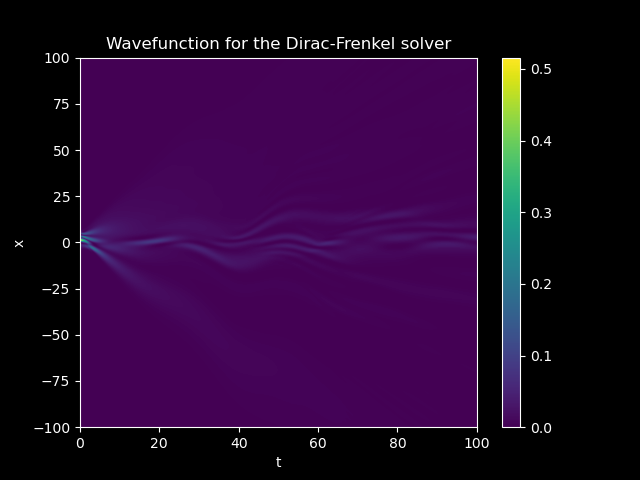

In [15]:

# plot the wavefunction
plt.figure()
t_skip = int(0.1/dt)
plt.imshow(np.abs(psi[:,::t_skip])**2, aspect='auto', extent=[0, t_final, grid_a, grid_b])
plt.colorbar()
plt.title('Wavefunction for the Dirac-Frenkel solver')
plt.xlabel('t')
plt.ylabel('x')
plt.savefig('wavefunction.png')
plt.show()




In [20]:
# perform grid simulation

def V_fun_exact(x):
    return -1.0 * (x**2 + 2)**(-0.5)

grid_sim.set_potential(V_fun)
grid_sim.set_laser_pulse(laser)
grid_sim.set_laser_potential(lambda x: -x)
grid_sim.prepare(normalize_wavefunction=False)

psi_grid = np.zeros((grid_ng, len(t_range)+1), dtype=complex)
psi_grid[:,0] = grid_sim.psi

def callback(grid_sim: Simulator):
    psi_grid[:,grid_sim.t_index] = grid_sim.psi
    if grid_sim.t_index % 1000 == 0:
        ic(grid_sim.t_index, grid_sim.t)

grid_sim.simulate(callback=callback)



ic| message: 'Potential function set set.'
ic| message: 'Laser pulse set.'
ic| message: 'Laser potential set.'
ic| 'Using given initial condition function. '
ic| 'Running simulation...'


  0%|          | 0/10000 [00:00<?, ?it/s]

ic| grid_sim.t_index: 0, grid_sim.t: 0.0
ic| grid_sim.t_index: 1000, grid_sim.t: 10.0
ic| grid_sim.t_index: 2000, grid_sim.t: 20.0
ic| grid_sim.t_index: 3000, grid_sim.t: 30.0
ic| grid_sim.t_index: 4000, grid_sim.t: 40.0
ic| grid_sim.t_index: 5000, grid_sim.t: 50.0
ic| grid_sim.t_index: 6000, grid_sim.t: 60.0
ic| grid_sim.t_index: 7000, grid_sim.t: 70.0
ic| grid_sim.t_index: 8000, grid_sim.t: 80.0
ic| grid_sim.t_index: 9000, grid_sim.t: 90.0
ic| grid_sim.t_index: 10000, grid_sim.t: 100.0


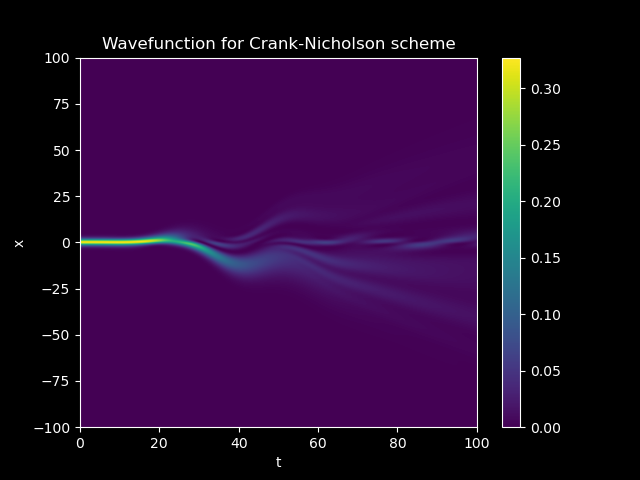

In [21]:

# plot the wavefunction
plt.figure()
t_skip = int(0.1/dt)
plt.imshow(np.abs(psi_grid[:,::t_skip])**2, aspect='auto', extent=[0, t_final, grid_a, grid_b])
plt.colorbar()
plt.title('Wavefunction for Crank-Nicholson scheme')
plt.xlabel('t')
plt.ylabel('x')
plt.savefig('wavefunction.png')
plt.show()

Help on function colorbar in module matplotlib.pyplot:

colorbar(mappable=None, cax=None, ax=None, **kwargs)
    Add a colorbar to a plot.
    
    Parameters
    ----------
    mappable
        The `matplotlib.cm.ScalarMappable` (i.e., `.AxesImage`,
        `.ContourSet`, etc.) described by this colorbar.  This argument is
        mandatory for the `.Figure.colorbar` method but optional for the
        `.pyplot.colorbar` function, which sets the default to the current
        image.
    
        Note that one can create a `.ScalarMappable` "on-the-fly" to
        generate colorbars not attached to a previously drawn artist, e.g.
        ::
    
            fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    
    cax : `~matplotlib.axes.Axes`, optional
        Axes into which the colorbar will be drawn.  If `None`, then a new
        Axes is created and the space for it will be stolen from the Axes(s)
        specified in *ax*.
    
    ax : `~matplotlib.axes.Axes` or iter

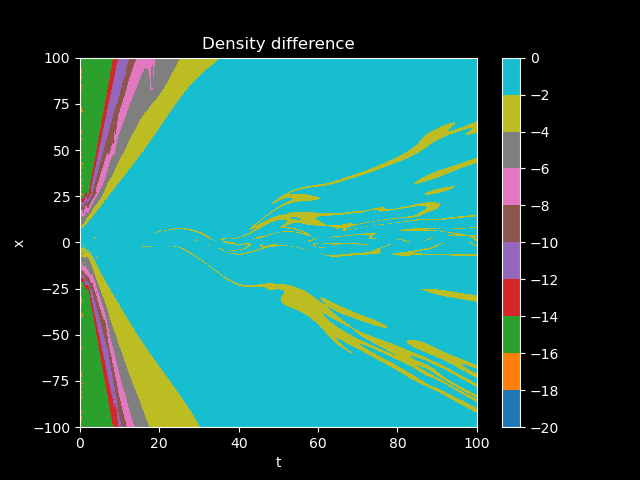

In [22]:
# compare

# renormalize psi for every time step

# psi_renorm = np.zeros_like(psi)
# for i in range(len(t_range)+1):
#     psi_norm = np.linalg.norm(psi[:,i]) * dx**.5
#     psi_renorm[:,i] = psi[:,i] / psi_norm

plt.figure()
delta = np.abs(psi[:,::t_skip]) - np.abs(psi_grid[:,::t_skip])
plt.imshow(np.log10(np.abs(delta) + 1e-20), vmin=-20.0, vmax=0.0, aspect='auto', extent=[0, t_final, grid_a, grid_b], cmap='tab10')
# display colormap with ticks at 1e-22, 1e-20, 1e-18, ..., 1e-2.
ticks = np.linspace(-20,0,11)
plt.colorbar(ticks=ticks)
plt.title('Density difference')
plt.xlabel('t')
plt.ylabel('x')
help(plt.colorbar)

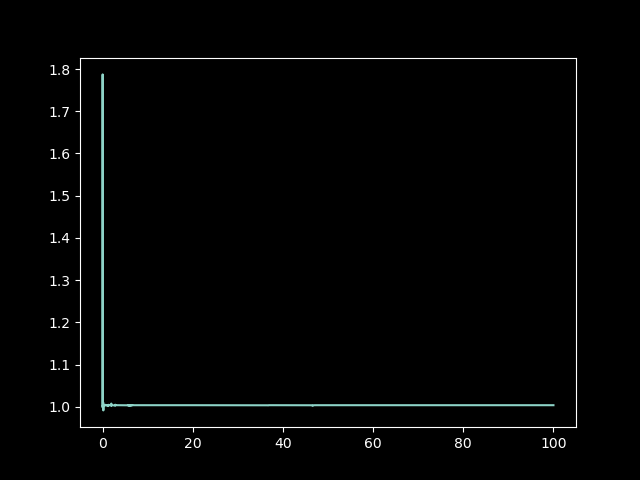

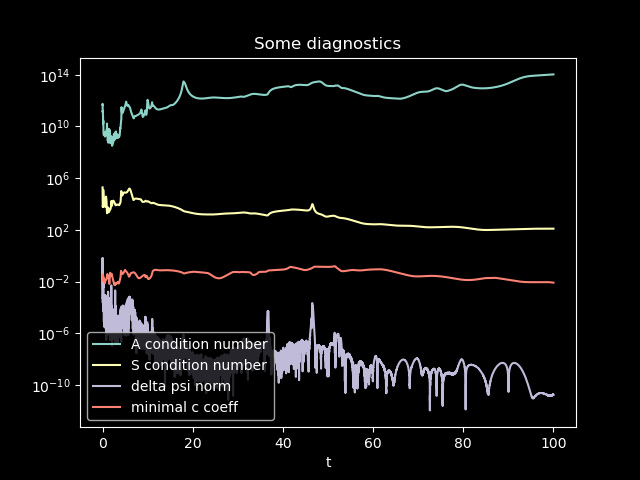

In [23]:
# here the time evolution terminated
i_term = i

diff_psi_norm = np.diff(psi_norm) 
%matplotlib widget
plt.figure()
plt.semilogy(t_range[:i_term], A_cond[:i_term], label='A condition number')
plt.semilogy(t_range[:i_term], S_cond[:i_term], label='S condition number')
plt.semilogy(t_range[:i_term], np.abs(diff_psi_norm[:i_term]), label='delta psi norm')
plt.semilogy(t_range[:i_term], np.min(np.abs(c[:,:i_term]), axis=0), label='minimal c coeff')
plt.xlabel('t')
plt.title('Some diagnostics')
plt.legend()

plt.figure()
plt.plot(t_range[:i_term], psi_norm[:i_term], label='psi norm')
plt.show()

/Users/simenkva/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


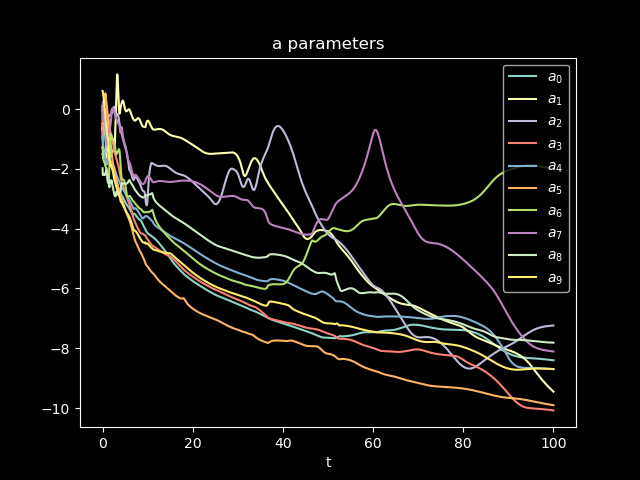

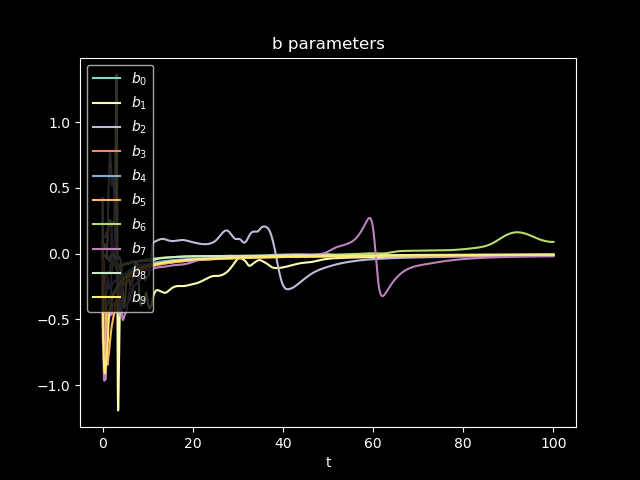

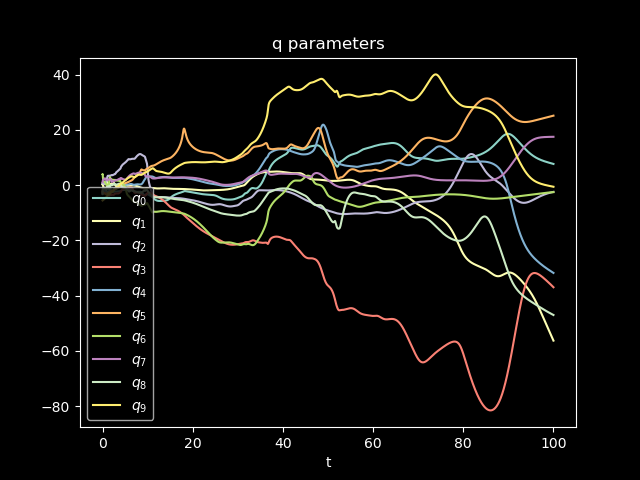

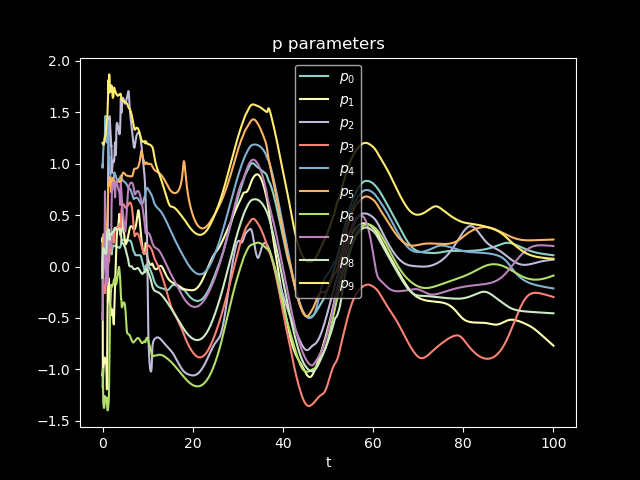

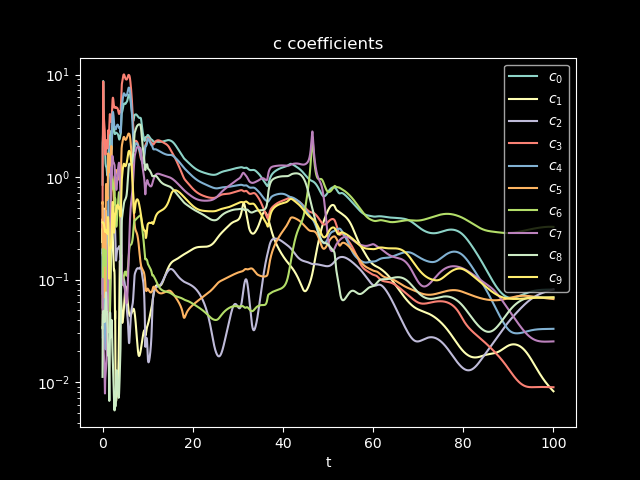

In [24]:
# plot the parameters
param_names = ['a', 'b', 'q', 'p'] #gaussians.param_names

for p in range(gaussians.n_par):
    plt.figure()
    plt.plot(t_range[:i_term], z[:,:i_term].reshape((gaussians.n_par, n_gauss, i_term))[p,:,:].T)
    plt.xlabel('t')
    legend = [f'${param_names[p]}_{i}$' for i in range(n_gauss)]
    plt.legend(legend)
    plt.title(f'{param_names[p]} parameters')
    plt.show()
    
# plit the coefficients
plt.figure()
plt.semilogy(t_range[:i_term], np.abs(c[:,:i_term].T))
plt.legend([f'$c_{i}$' for i in range(n_gauss)])
plt.xlabel('t')
plt.title('c coefficients')
plt.show()

    

In [14]:
V

array([-0.00997959, -0.00998999, -0.01000039, ..., -0.01001081,
       -0.01000039, -0.00998999])

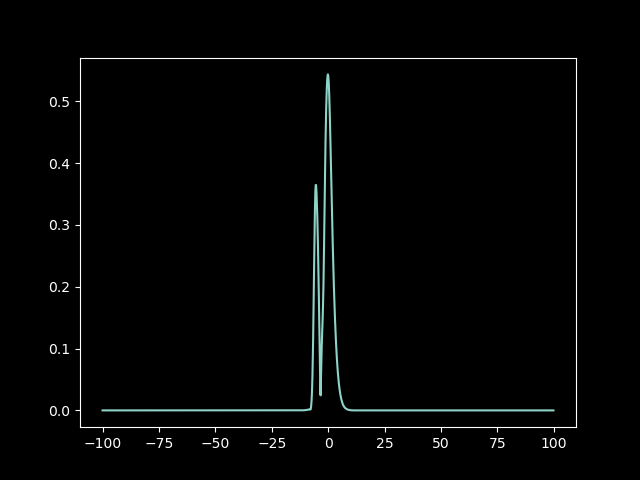

In [28]:
plt.figure()
plt.plot(x, np.abs(psi[:,1]))
plt.show()


In [17]:
df.z_pot

array([[ 6.14930234e-01, -6.20286686e-01, -1.84235258e+00,
        -3.10735059e+00, -4.36222260e+00, -5.71768557e+00,
        -7.15736123e+00, -8.70804190e+00, -9.03799213e+00,
        -8.93329381e+00,  6.14930234e-01, -6.20286686e-01,
        -1.84235258e+00, -3.10735059e+00, -4.36222260e+00,
        -5.71768557e+00, -7.15736123e+00, -8.70804190e+00,
        -9.03799213e+00, -8.93329381e+00],
       [ 1.33303387e-07,  7.48816543e-04,  6.54790183e-04,
        -2.69202492e-07, -1.81509876e-08,  8.14965881e-06,
         8.41268612e-05, -8.04168106e-04, -4.21331945e-04,
        -1.77490936e-04, -1.33303387e-07, -7.48816543e-04,
        -6.54790183e-04,  2.69202492e-07,  1.81509876e-08,
        -8.14965881e-06, -8.41268612e-05,  8.04168106e-04,
         4.21331945e-04,  1.77490936e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.0